In [1]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [2]:

# Connect to  DB
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)

query = """
SELECT headline, sentiment_score, price_label_1h
FROM headlines
WHERE price_label_1h IS NOT NULL

"""
df = pd.read_sql(query, conn)
conn.close()

# Quick preview
print(df.head())


                                            headline  sentiment_score  \
0  GM's $4 billion US plant investment will allow...           -0.133   
1  Microsoft Debuts ROG Xbox Ally Handhelds, Mark...            0.500   
2  Ameresco Celebrates the Completion Solar Canop...            0.900   
3  UK Regulator Partners with Nvidia to Help Bank...            0.300   
4      Apple to Open its AI Models to App Developers            0.000   

  price_label_1h  
0        Neutral  
1        Neutral  
2           Down  
3        Neutral  
4        Neutral  


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_72412/1607026733.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:
print(df['price_label_1h'].value_counts())

price_label_1h
Neutral    1027
Up           78
Down         63
Name: count, dtype: int64


In [ ]:
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)

# Query headlines table
query = "SELECT headline, sentiment_score, price_label_24h FROM headlines WHERE price_label_24h IS NOT NULL"

# Load into pandas DataFrame
df = pd.read_sql(query, conn)

conn.close()

print(df.head())


                                            headline  sentiment_score  \
0  GM's $4 billion US plant investment will allow...           -0.133   
1  Microsoft Debuts ROG Xbox Ally Handhelds, Mark...            0.500   
2  Ameresco Celebrates the Completion Solar Canop...            0.900   
3  UK Regulator Partners with Nvidia to Help Bank...            0.300   
4      Apple to Open its AI Models to App Developers            0.000   

  price_label_24h  
0            Down  
1              Up  
2              Up  
3              Up  
4         Neutral  


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_72412/3055546509.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:

# Use 24h label
X = df[['sentiment_score']]
y = df['price_label_24h']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train model with class balancing
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

        Down       0.32      0.21      0.25        53
     Neutral       0.57      0.25      0.35       102
          Up       0.31      0.66      0.42        65

    accuracy                           0.36       220
   macro avg       0.40      0.37      0.34       220
weighted avg       0.43      0.36      0.35       220

[[11  7 35]
 [14 26 62]
 [ 9 13 43]]


In [6]:
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)
# Pull full data needed for 4d label
query = """
    SELECT headline, sentiment_score, price_at_time, price_4d_later
    FROM headlines
    WHERE price_at_time IS NOT NULL AND price_4d_later IS NOT NULL
"""
df = pd.read_sql(query, conn)

# Labeling function
def label_price_4d(row):
    change = (row['price_4d_later'] - row['price_at_time']) / row['price_at_time']
    if change > 0.01:
        return 'Up'
    elif change < -0.01:
        return 'Down'
    else:
        return 'Neutral'

# Create new column
df['price_label_4d'] = df.apply(label_price_4d, axis=1)


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_72412/2764492087.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [7]:
import sys
sys.path.append("/Users/qasim/Documents/Analyzer Internship Project/Summer_IST495/stock-sentiment-project/Sentiment Scripts")

from sentiment_score_intro import sentiment_dict


✅ Sentiment tagging complete.


In [ ]:
import pandas as pd
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)

query = """
SELECT
    headline,
    sentiment_score,
    sentiment_confidence,
    price_change_pct_1h,
    price_change_pct_4h,
    price_label_4d
FROM headlines
WHERE price_label_4d IS NOT NULL
"""

df = pd.read_sql(query, conn)
conn.close()

# Map the sentiment_confidence to numeric
confidence_map = {
    'High': 1.0,
    'Medium': 0.66,
    'Low': 0.33,
    None: 0.0
}
df['confidence_score'] = df['sentiment_confidence'].map(confidence_map)
print(df['confidence_score'].isna().sum())  # should now be 0


# define X and y
X = df[['sentiment_score', 'confidence_score', 'price_change_pct_1h', 'price_change_pct_4h']]
y = df['price_label_4d']

#Drop rows with NaNs
X = X[y.notna() & X['confidence_score'].notna()]
y = y[y.notna() & X['confidence_score'].notna()]


0


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_72412/2567161874.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:



mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#Training model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

        Down       0.52      0.46      0.49        84
     Neutral       0.43      0.46      0.45        67
          Up       0.42      0.45      0.44        60

    accuracy                           0.46       211
   macro avg       0.46      0.46      0.46       211
weighted avg       0.46      0.46      0.46       211

[[39 22 23]
 [22 31 14]
 [14 19 27]]


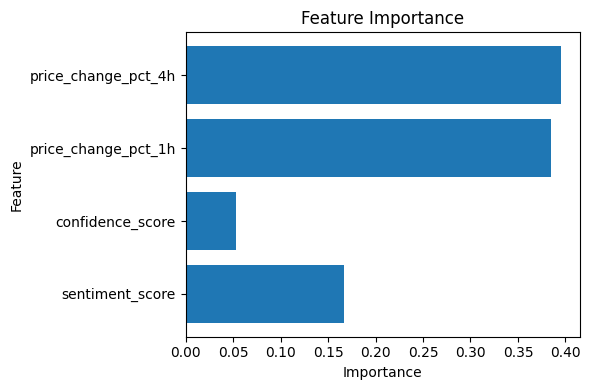

In [10]:
import matplotlib.pyplot as plt

# Check feature importances
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6, 4))
plt.barh(feature_names, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

